In [ ]:
!unzip photos.zip

Label =  blazer


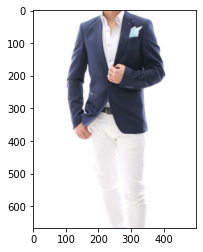

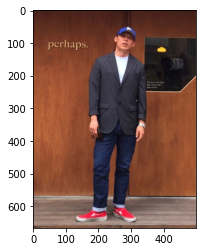

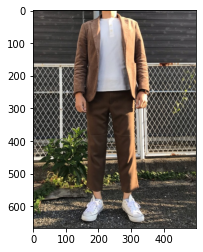

Label =  cardigan


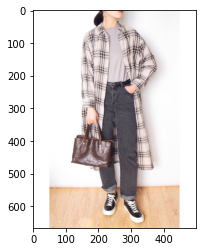

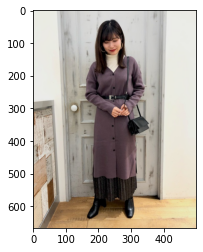

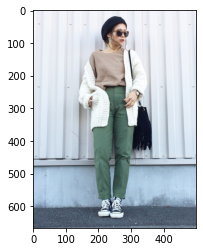

Label =  coat


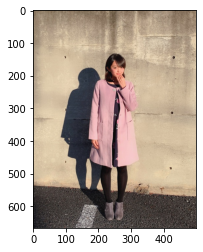

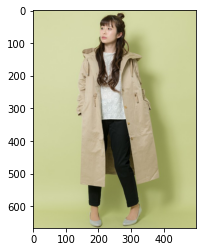

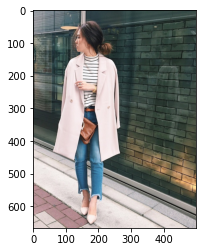

Label =  jacket


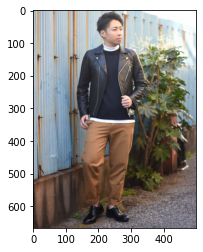

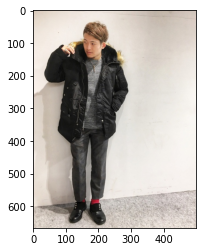

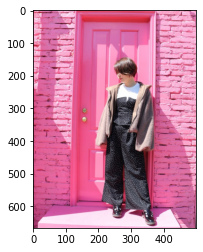

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random

random.seed(1223)
labels = ['blazer', 'cardigan', 'coat', 'jacket']
for i in range(4):
    print("Label = ", labels[i])
    basepath = os.path.join("photos/train", labels[i], "*.jpg")
    cand_fn = glob.glob(basepath)
    for afn in random.choices(cand_fn, k = 3):    
        img = Image.open(afn)
        plt.imshow(img)
        plt.show()

### Q1

In [11]:
import os , glob

sets = ['train', 'valid', 'test']
labels = ['blazer', 'cardigan', 'coat', 'jacket']

for set in sets:
    tmp = [0, 0, 0, 0]
    sum = 0
    for i in range(len(labels)):
        filename = "photos/"+set+"/"+labels[i]+"/*.jpg"
        sum += len(glob.glob((filename)))
        tmp[i] = (len(glob.glob((filename))))
        
    print('There are %d photos in %s set' %(sum, set))
    for i in range(len(labels)):       
        print("In %s set, there are %d photos for %s, which accounts for %f %%"%(set, tmp[i], labels[i], tmp[i]/sum*100 ))
    print('-' * 50)

There are 1041 photos in train set
In train set, there are 97 photos for blazer, which accounts for 9.317963 %
In train set, there are 237 photos for cardigan, which accounts for 22.766571 %
In train set, there are 296 photos for coat, which accounts for 28.434198 %
In train set, there are 411 photos for jacket, which accounts for 39.481268 %
--------------------------------------------------
There are 105 photos in valid set
In valid set, there are 7 photos for blazer, which accounts for 6.666667 %
In valid set, there are 36 photos for cardigan, which accounts for 34.285714 %
In valid set, there are 27 photos for coat, which accounts for 25.714286 %
In valid set, there are 35 photos for jacket, which accounts for 33.333333 %
--------------------------------------------------
There are 146 photos in test set
In test set, there are 9 photos for blazer, which accounts for 6.164384 %
In test set, there are 42 photos for cardigan, which accounts for 28.767123 %
In test set, there are 43 ph

#### 猜測準確率是 jacket>coat>cardigan>blazer，基於各自資料量大小的排序

### Q2

In [12]:
#discuss with TA
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import PIL

train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

test_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

train_data = datasets.ImageFolder(root='photos/train', transform=train_transformer)
valid_data = datasets.ImageFolder(root='photos/valid', transform=test_transformer)
test_data = datasets.ImageFolder(root='photos/test', transform=test_transformer)

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
!pip3 install livelossplot

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from livelossplot import PlotLosses

device = torch.device('cuda:0')

def CNN(model, optimizer, loss_function = nn.CrossEntropyLoss(), num_epochs = 200, patient = 20, best_trained_fn):
    liveloss = PlotLosses(step_names = "Epochs")

    for epoch in range(1, num_epochs + 1):
        Loss, correct, cnt = 0.0, 0, 0
        logs = {}
        for batch_idx, (x, y) in enumerate(train_dataloader):
            model.train()
            x, y = x.to(device), y.to(device)  
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_function(pred, y)
            loss.backward()
            optimizer.step()
            Loss += loss.item() * x.shape[0]
            correct += torch.sum(torch.max(pred, dim=1)[1]  == y).item()
            cnt += target_.size(0)
        
        new_loss = Loss / cnt
        new_acc = correct/cnt * 100
        train_acc.append(new_acc)
        train_loss.append(new_loss)
        logs['loss'] = new_loss
        logs['acc'] = new_acc

        Loss = 0
        cnt = 0
        correct = 0
        with torch.no_grad():
            model.eval()
            for x, y in valid_dataloader:
                x, y = x.to(device), y.to(device) 
                pred = model(x)
                loss = loss_function(pred, y)
                Loss += loss.item() * x.shape[0]
                correct_t += torch.sum(torch.max(pred, dim=1)[1] == y).item()
                cnt += y.size(0)
            new_acc = 100 * correct / cnt
            new_loss = Loss / cnt
            val_acc.append(new_acc)
            val_loss.append(new_loss)
      
            logs['val_loss'] = val_loss[-1]
            logs['val_acc'] = val_acc[-1]
            liveloss.update(logs)
            liveloss.send()

            if val_loss[-1] < valid_loss_min:
                valid_loss_min = val_loss[-1]
                best_model_epoch = epoch
                torch.save(model.state_dict(), best_trained_fn)
            if epoch > (best_model_epoch + patient):
                break
      
    model_pred = models.resnet50().cuda()
    model_pred.fc = nn.Linear(model_pred.fc.in_features , 4).cuda()
    model_pred.load_state_dict(torch.load(best_trained_fn)) 
    model_pred.eval()  

    correct = 0
    cnt = 0
    confusion_matrix = torch.zeros(4, 4)
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device) 
            pred = model_pred(x)
            cnt += y.size(0)
            correct += (torch.max(pred.data, 1)[1] == y).sum().item()
            for i in y.view(-1):
              for j in pred.view(-1):
                confusion_matrix[i.long()][j.long()] += 1
    

    print('Accuracy: %.2f %%' % (100 * correct / cnt))
    print('confusion matrix:', '\n', confusion_matrix.numpy())
    print("For class: blazer, cardigan, coat, jacket, respectively...")
    print('per-class accuracy:', ['%.2f %%' % i for i in (100 * confusion_matrix.diag() / confusion_matrix.sum(1)).tolist()])

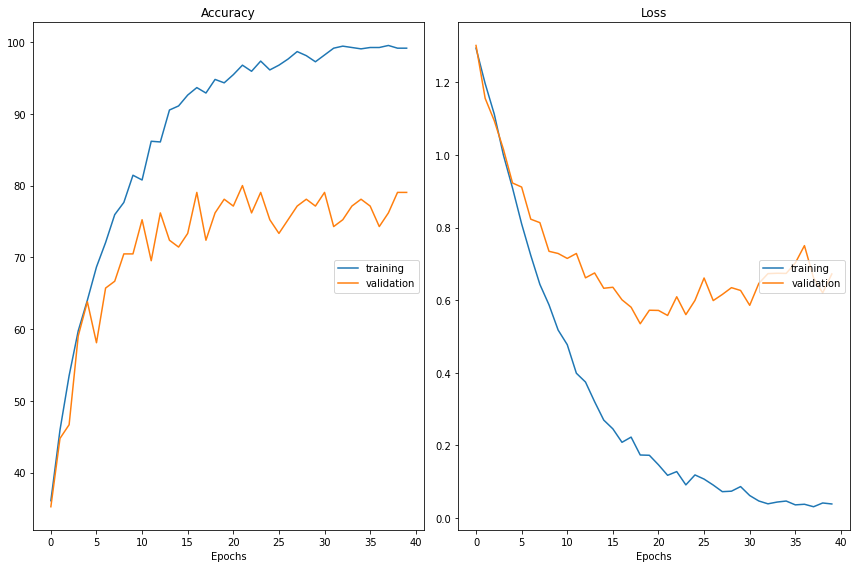

Accuracy
	training         	 (min:   36.080, max:   99.527, cur:   99.148)
	validation       	 (min:   35.238, max:   80.000, cur:   79.048)
Loss
	training         	 (min:    0.031, max:    1.294, cur:    0.039)
	validation       	 (min:    0.535, max:    1.301, cur:    0.672)
Accuracy: 78.77 %
confusion matrix: 
 [[ 7.  0.  1.  1.]
 [ 0. 29.  5.  8.]
 [ 1.  5. 33.  4.]
 [ 1.  4.  1. 46.]]
For class: blazer, cardigan, coat, jacket, respectively...
per-class accuracy: ['77.78 %', '69.05 %', '76.74 %', '88.46 %']


In [18]:
print("Using SGD")

model = models.resnet50(pretrained=True).cuda()
model.fc = nn.Linear(model.fc.in_features , 4).cuda()

CNN(model, optim.SGD(model.parameters(), lr = 0.0005) , best_trained_fn = 'resnet50_pretrain_ft_sgd_1.pt')    

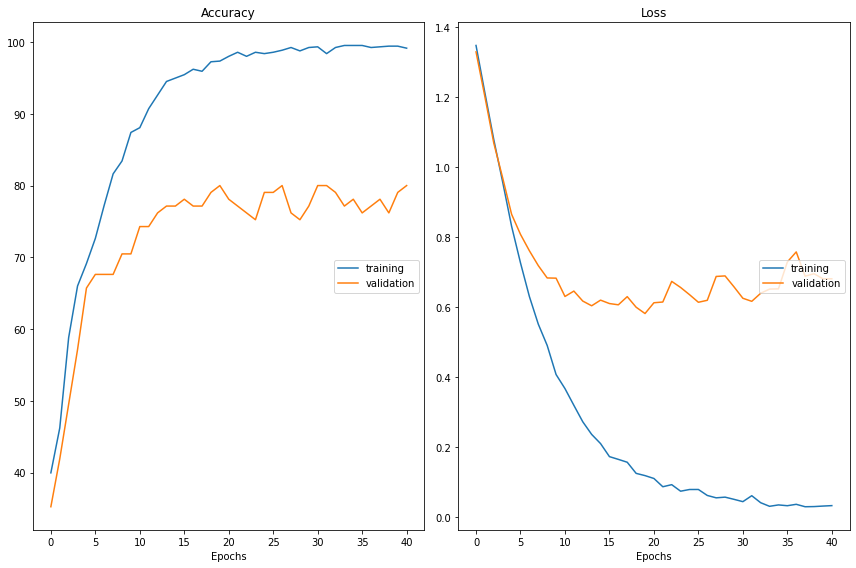

Accuracy
	training         	 (min:   39.962, max:   99.527, cur:   99.148)
	validation       	 (min:   35.238, max:   80.000, cur:   80.000)
Loss
	training         	 (min:    0.030, max:    1.347, cur:    0.033)
	validation       	 (min:    0.581, max:    1.329, cur:    0.681)
Accuracy: 80.14 %
confusion matrix: 
 [[ 7.  0.  1.  1.]
 [ 0. 26.  5. 11.]
 [ 1.  2. 36.  4.]
 [ 0.  1.  3. 48.]]
For class: blazer, cardigan, coat, jacket, respectively...
per-class accuracy: ['77.78 %', '61.90 %', '83.72 %', '92.31 %']


In [19]:
print("Using ADAM")

model = models.resnet50(pretrained=True).cuda()
model.fc = nn.Linear(model.fc.in_features , 4).cuda()

CNN(model, optim.Adam(model.parameters(), lr = 0.00001), best_trained_fn = 'resnet50_pretrain_ft_adam_1.pt')  

### 討論
* 最差的結果反而是cardigan而非blazer，可能因為cardigan跟其他的衣服長太像，較難辨識。

### Q3

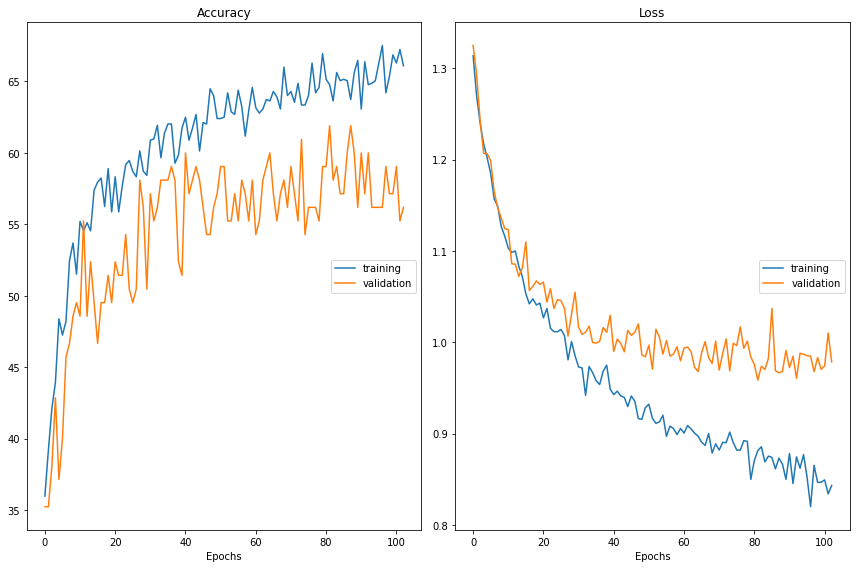

Accuracy
	training         	 (min:   35.985, max:   67.519, cur:   66.098)
	validation       	 (min:   35.238, max:   61.905, cur:   56.190)
Loss
	training         	 (min:    0.820, max:    1.314, cur:    0.843)
	validation       	 (min:    0.958, max:    1.325, cur:    0.978)
Accuracy: 67.81 %
confusion matrix: 
 [[ 4.  0.  1.  4.]
 [ 0. 29.  4.  9.]
 [ 0.  7. 26. 10.]
 [ 1.  7.  4. 40.]]
For class: blazer, cardigan, coat, jacket, respectively...
per-class accuracy: ['44.44 %', '69.05 %', '60.47 %', '76.92 %']


In [21]:
print("Using SGD")

model = models.resnet50(pretrained=True)
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

model.fc = nn.Linear(model.fc.in_features , 4).cuda() 

CNN(model, optim.SGD(model.parameters(), lr = 0.0002), best_trained_fn = 'resnet50_pretrain_ft_last_sgd_1.pt')  

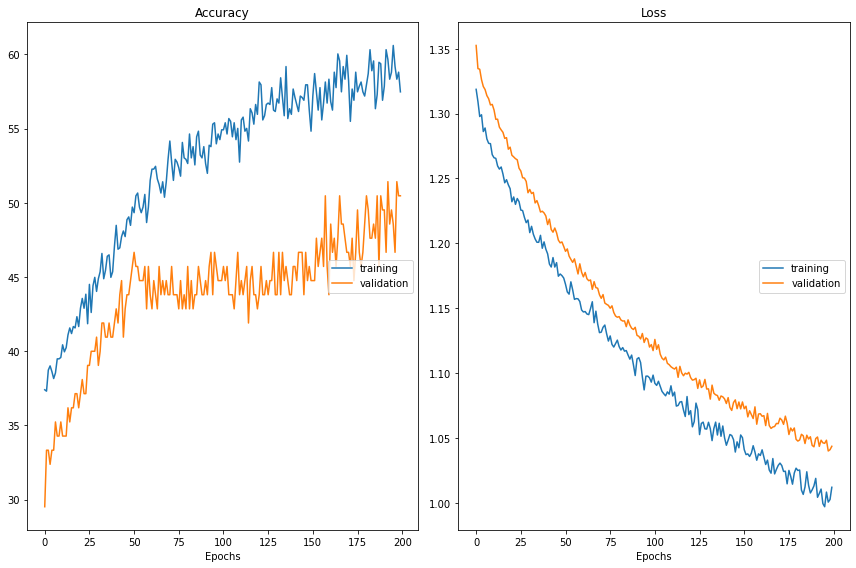

Accuracy
	training         	 (min:   37.311, max:   60.606, cur:   57.481)
	validation       	 (min:   29.524, max:   51.429, cur:   50.476)
Loss
	training         	 (min:    0.997, max:    1.319, cur:    1.012)
	validation       	 (min:    1.040, max:    1.353, cur:    1.044)
Accuracy: 63.70 %
confusion matrix: 
 [[ 0.  0.  1.  8.]
 [ 0. 27.  2. 13.]
 [ 0.  6. 20. 17.]
 [ 0.  4.  2. 46.]]
For class: blazer, cardigan, coat, jacket, respectively...
per-class accuracy: ['0.00 %', '64.29 %', '46.51 %', '88.46 %']


In [23]:
print("Using Adam")

model = models.resnet50(pretrained=True).cuda
for p in model.parameters():
    p.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 4).cuda() 

CNN(model, optim.Adam(model.parameters(), lr = 0.00001), best_trained_fn = 'resnet50_pretrain_ft_last_adam_1.pt')    

### Q4

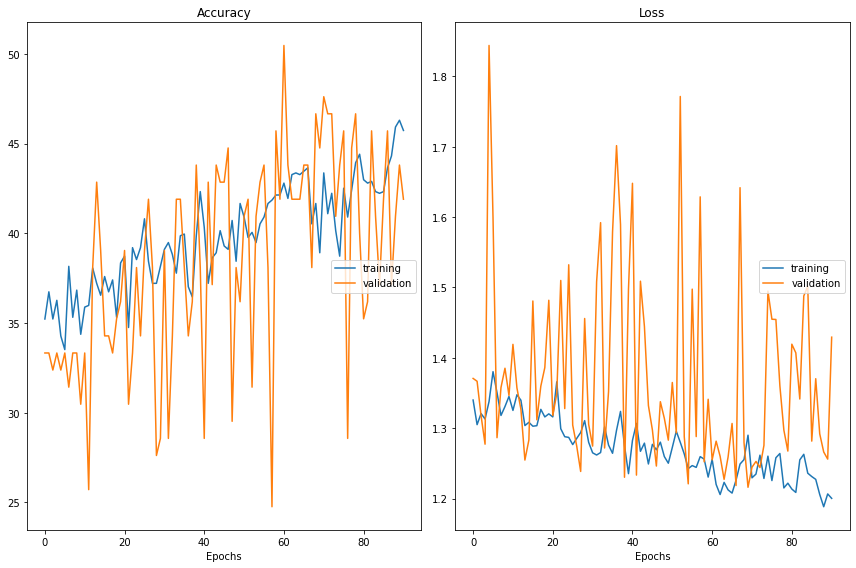

Accuracy
	training         	 (min:   33.523, max:   46.307, cur:   45.739)
	validation       	 (min:   24.762, max:   50.476, cur:   41.905)
Loss
	training         	 (min:    1.188, max:    1.380, cur:    1.200)
	validation       	 (min:    1.216, max:    1.844, cur:    1.429)
Accuracy: 38.36 %
confusion matrix: 
 [[ 0.  1.  3.  5.]
 [ 0. 20.  9. 13.]
 [ 0. 15.  8. 20.]
 [ 0. 13. 11. 28.]]
For class: blazer, cardigan, coat, jacket, respectively...
per-class accuracy: ['0.00 %', '47.62 %', '18.60 %', '53.85 %']


In [24]:
print("Using SGD")

model = models.resnet50(pretrained=False).cuda()

model.fc = nn.Linear(model.fc.in_features , 4).cuda()  

CNN(model,  optim.SGD(model.parameters(), lr = 0.0005), best_trained_fn = 'resnet50_sgd_1.pt')    

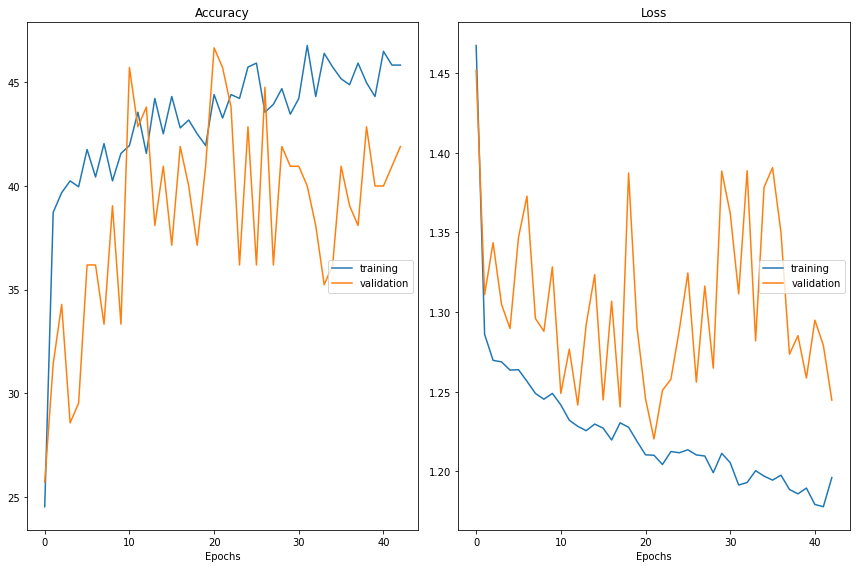

Accuracy
	training         	 (min:   24.527, max:   46.780, cur:   45.833)
	validation       	 (min:   25.714, max:   46.667, cur:   41.905)
Loss
	training         	 (min:    1.178, max:    1.467, cur:    1.196)
	validation       	 (min:    1.220, max:    1.452, cur:    1.245)
Accuracy: 37.67 %
confusion matrix: 
 [[ 0.  5.  0.  4.]
 [ 0. 20.  5. 17.]
 [ 0. 14.  1. 28.]
 [ 0. 14.  4. 34.]]
For class: blazer, cardigan, coat, jacket, respectively...
per-class accuracy: ['0.00 %', '47.62 %', '2.33 %', '65.38 %']


In [25]:
print("Using Adam")

model = models.resnet50(pretrained=False).cuda()

model.fc = nn.Linear( model.fc.in_features, 4).cuda()

CNN(model, optim.Adam(model.parameters(), lr = 0.00002),  best_trained_fn = 'resnet50_adam_1.pt')    

### Q5


|model setting                                 | Test Accuracy w/ SGD| Test Accuracy w/ ADAM|
|---------------------------------------------|---------------------|---------------------|
|Q2: Pretrained weights, Fine-tune all layers     |  78.77%  | 80.14%   |
|Q3: Pretrained weights, Fine-tune the last layer | 67.81%   | 63.7% | 
|Q4: No pretrained weights              | 38.36%   | 37.67% |

* 使用pretrained weight再fine tune 所有layer的效果明顯最好，而不用pretrained weight的效果非常差。

* optimizer效果互有好壞，應當都試過再case by case選取較好的一個。